# __Свяжем предобученную BERT с графовой кластеризацией (через igraph)__

# _pip, import_

In [2]:
!pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 34.3 MB/s eta 0:00:00


In [3]:
import igraph as ig
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
# Связь с файлами на Google drıve
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# _загрузка текстов и их эмбеддингов <font color='orange'><small>(all_texts, ebeddings)_  

In [6]:
# Загрузка текстов

# _______ Параметры ______________
chunk_size = 1000 # # Размер чанка при загрузке текстов
# Google Colab
file_path_data = '/content/drive/My Drive/Example_ML/classification_text/Classifiers/articles.csv'
# Локально
# file_path_data = 'articles.csv'
text_column = "title"  # Название колонки с текстами

# _________ Загрузка _______________________

all_texts = []
max_text = 5000 # maximum number of texts !!! Используется в названии файла !!!
current_count = 0

for chunk in tqdm(pd.read_csv(file_path_data, chunksize=chunk_size), desc="Обработка данных"):
    if text_column not in chunk.columns:
        print(f"Ошибка: в CSV нет колонки '{text_column}'. Доступные: {chunk.columns}")
        break

    texts = chunk[text_column].dropna().tolist()  # Убираем пустые значения

    remaining = max_text - current_count
    if remaining <= 0:
        break
    # Обрезаем чанк, если он превышает лимит
    if len(texts) > remaining:
        texts = texts[:remaining]
    all_texts.extend(texts)  # Объединяем части текста вместе

    current_count += len(texts)
    if current_count >= max_text:
        break

len(all_texts) # list

Обработка данных: 4it [00:00, 10.42it/s]


5000

In [7]:
# Загрузка эмбеддингов

# _________ Параметры ____________
batch_size = 1000  # Размер батча

# Google Colab
file_path_embeddings = f'/content/drive/My Drive/Example_ML/classification_text/Classifiers/Data/embeddings_rubert-tiny2_text_{max_text}.npy'  # Путь к файлу эмбеддингов
# Локально
# file_path_embeddings = './Data/embeddings_rubert-tiny2.npy'  # Файл с эмбеддингами

# _________ Загрузка _______________________
# Загружаем файл в режиме "чтение без загрузки в память"
embeddings_mmap = np.load(file_path_embeddings, mmap_mode="r")

num_samples = embeddings_mmap.shape[0] # Определяем количество примеров (должно быть = max_text)
all_embeddings = [] # Пустой список для хранения частей эмбеддингов

# Читаем файл частями
for i in range(0, num_samples, batch_size):
    batch = embeddings_mmap[i : i + batch_size]  # Загружаем батч
    all_embeddings.append(batch)  # Добавляем в список

embeddings = np.vstack(all_embeddings) # Объединяем все части в один массив NumPy

print(f"Форма объединённого массива: {embeddings.shape}") # Проверяем размер итогового массива

Форма объединённого массива: (5000, 312)


In [ ]:
embeddings.shape

(5000, 312)

# 1. Кластеризуем с __Leiden__

## _строим граф схожести между текстами (используя __cosine similarity__ между эмбеддингами, преобразуем её в граф)_

In [8]:
# Вычислим попарное косинусное сходство
similarity_matrix = cosine_similarity(embeddings)
# similarity_matrix

Что здесь: `similarity_matrix = cosine_similarity(X)`  
Строится полная матрица N x N попарных косинусных сходств между всеми векторами.  
Это симметричная матрица: similarity_matrix[i, j] = similarity_matrix[j, i].  
Используется для построения полносвязного графа, где потом ты отсекаешь по threshold.  
⚠️ Недостатки: Память: при N = 50 000 матрица = ~19 ГБ в float64!  
Много шумных или слабых связей, даже если между двумя текстами почти нет сходства — у них будет какое-то значение.

In [9]:
threshold = 0.7 # Порог - степень похожести (подбираемый, см. ниже)

# Список рёбер (i, j) со сходством > threshold
edges = [] # массив ребер
weights = [] # массив весов ребер
N = similarity_matrix.shape[0] # у нас 5000


#  Строим список рёбер графа на основе косинусного сходства между эмбеддингами,
# где каждый текст — это узел графа,
# а ребро между двумя узлами появляется, если их сходство выше заданного порога.

for i in range(N):                        # Проходим по всем парам эмбеддингов
    for j in range(i + 1, N):             # Только уникальные пары (i < j), без повторений и самих себя
        sim = similarity_matrix[i, j]     # Достаём косинусное сходство между текстом i и j
        if sim > threshold:               # Если сходство выше порога (например, 0.7)
            edges.append((i, j))          # Добавляем ребро в список: i связано с j
            weights.append(sim)           # Сохраняем вес ребра (сходство)


# edges: список кортежей (i, j) — индексы текстов, между которыми есть "похожесть".
# weights: веса этих рёбер — значения сходства.
# Эти данные идут в igraph
print(edges[9:10])
print(weights[9:10])

[(0, 18)]
[np.float32(0.76878875)]


### насколько корректно выбран порог

In [ ]:
# Оценим "разумность" выбора величины threshold, исходя из распределения весов (сходств). Лучше, чем угадывать ее "на глаз".

weights_array = np.array(weights)
print("min:", weights_array.min())
print("max:", weights_array.max())
print("mean:", weights_array.mean())
print("median:", np.median(weights_array))

min: 0.30122253
max: 0.99202895
mean: 0.6699383
median: 0.66737926


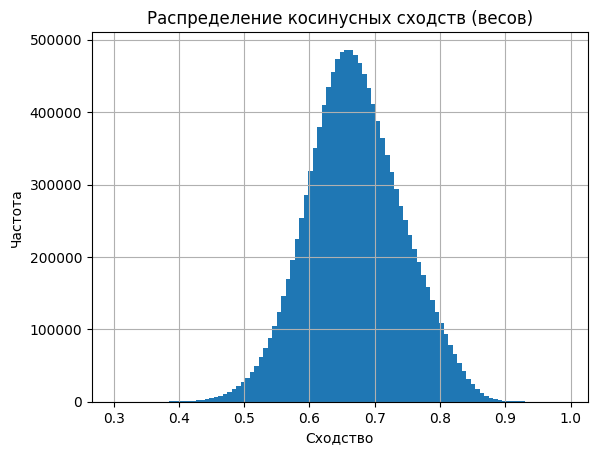

In [ ]:
import matplotlib.pyplot as plt

plt.hist(weights_array, bins=100)
plt.title("Распределение косинусных сходств (весов)")
plt.xlabel("Сходство")
plt.ylabel("Частота")
plt.grid(True)
plt.show()

In [ ]:
threshold_exaple = np.percentile(weights_array, 80)
threshold_exaple
# Усли взять threshold = np.percentile(weights_array, 90),
# то оставим только 10% самых сильных связей, игнорируя слабые.

np.float32(0.73182523)

### далее

In [10]:
# Создаём граф
g = ig.Graph(edges=edges, directed=False)
g.es['weight'] = weights

## _кластеризуем_

In [ ]:
# Оценка к-ва получаемых кластеров по параметру "resolution"
for res in [0.7, 0.6, 0.5, 0.4, 0.3, 0.1]:
    clusters = g.community_leiden(weights=g.es['weight'], resolution=res)
    print(f"Resolution {res}: {len(clusters)} кластеров")

Resolution 0.7: 194 кластеров
Resolution 0.6: 158 кластеров
Resolution 0.5: 126 кластеров
Resolution 0.4: 99 кластеров
Resolution 0.3: 76 кластеров
Resolution 0.1: 35 кластеров


In [11]:
# Кластеризуем:

clusters = g.community_leiden(weights=g.es['weight'], resolution=0.01) # Leiden
# Или: clusters = g.community_multilevel(weights=g.es['weight'])  # Louvain

# Создаем датафрейм

# type(clusters) # type -> igraph.clustering.VertexClustering, не годится для сохранения в df
graph_labels = clusters.membership  # Преобразовываем в список меток для каждого узла
type(graph_labels)

df = pd.DataFrame({
    'text': all_texts,
    'embeddings': list(embeddings),  # Важно: список из массивов
    'cluster': graph_labels
})
# df[7:10]

# Подсчет к-ва классов
num_clusters = len(set(graph_labels))
print(f"Количество кластеров: {num_clusters}")

# Количественное распределение текстов по кластерам:
from collections import Counter
counts_cluster = Counter(graph_labels)
print(counts_cluster)

Количество кластеров: 12
Counter({0: 4986, 4: 3, 9: 2, 1: 1, 2: 1, 3: 1, 5: 1, 6: 1, 7: 1, 8: 1, 10: 1, 11: 1})


# 2. Кластеризуем с __FAISS для kNN-графа__

## Импорты и подготовка данных (нормализация эмбеддингов)

In [ ]:
!pip install faiss-cpu

In [14]:
import faiss
import numpy as np
import igraph as ig

In [ ]:
X_normalized = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
X_normalized

In [ ]:
print(embeddings[:1, :10])
print(X_normalized[:1, :10])
# Как видим, они и так были нормализованы

[[ 0.07518719 -0.00556178  0.0142403  -0.04957588 -0.01678801  0.0150027
   0.06352423 -0.07921577 -0.01654473  0.08945166]]
[[ 0.07518719 -0.00556178  0.0142403  -0.04957588 -0.01678801  0.0150027
   0.06352423 -0.07921577 -0.01654473  0.08945166]]


In [ ]:
vec = X_normalized  # берем первый вектор (X_normalized[0] или любой по индексу)
min_val = vec.min()
max_val = vec.max()

print(f"min: {min_val}, max: {max_val}")

min: -0.5314207077026367, max: 0.295122891664505


## Построение индекса и поиск kNN

In [15]:
k = 60  # число ближайших соседей

# ========= Примечание - у нас X_normalized = embeddings, т. е. embeddings уже
# нормализован, т.е. имеет те-же нормализованные значения, поэтому ниже используем
# везде embeddings.

# FAISS индекс для поиска по косинусной близости (внутри он использует скалярное произведение)
d = embeddings.shape[1]  # размерность эмбеддинга
index = faiss.IndexFlatIP(d)  # IP = Inner Product → для cosine similarity
index.add(embeddings.astype('float32'))  # FAISS работает только с float32

# Поиск ближайших k+1 соседей (включая себя)
similarities, indices = index.search(embeddings.astype('float32'), k + 1)


### Пояснения по коду и сравнение с построением графа вручную (с порогом)

- indices[i] — это список индексов k+1 ближайших соседей к точке i (включая саму точку)  
- similarities[i] — это список соответствующих косинусных сходств (т.к. мы нормализовали эмбеддинги, FAISS возвращает скалярное произведение ≈ cosine similarity)  

Что происходит здесь (в сравнении с простой процедурой similarity_matrix = cosine_similarity(X))  
```
index = faiss.IndexFlatIP(d)
index.add(X_normalized.astype('float32'))
similarities, indices = index.search(X_normalized.astype('float32'), k + 1)
```  
FAISS не строит полную матрицу — вместо этого находит k самых похожих векторов для каждого.  
Работает по внутреннему произведению (inner product), но ты нормализуешь вектора, чтобы превратить это в cosine similarity.  
Строится kNN-граф: у каждого узла ровно k связей (с его ближайшими соседями).  

✅ Преимущества:
```
Аспект	          cosine_similarity	      FAISS + kNN
Память	          Очень большая (N x N)	  Гораздо меньше (только N x k)
Связи	            Все со всеми	          Только k ближайших
Скорость	        Медленно при больших N	Очень быстро даже при 100k+
Тип графа	        Глобальный, плотный	    Локальный, разреженный
Контроль	        Через threshold	        Через k ближайших
```

## Построение графа на основе kNN

In [16]:
edges = []
weights = []

N = embeddings.shape[0]
for i in range(N):
    for j, sim in zip(indices[i][1:], similarities[i][1:]):  # Пропускаем себя
        edges.append((i, j))
        weights.append(sim)  # Уже косинусная похожесть

### Пояснения по принципу работы и сравнение с построением графа вручную (с порогом)

Что здесь происходит.  
Функция zip(a, b) объединяет два списка a и b в пары, или  
Объединяет каждый индекс соседа j и его сходство sim в пару (j, sim)  
- indices[i]       → список индексов ближайших соседей для точки i  
- similarities[i]  → список косинусных сходств для этих соседей  

⚠️ Но:  
Первый элемент в обоих списках — это сама точка i (сходство с собой = 1.0)  
Поэтому используем [1:] чтобы пропустить саму точку и взять только соседей:  
- indices[i][1:]       → индексы k ближайших соседей (без i)  
- similarities[i][1:]  → значения сходства с этими соседями  

Некоторые сравнения   
📦 Как это выглядит в памяти  

❌ __Полная матрица (cosine_similarity):__  
Размер: N x N Тип данных: float32 → 4 байта на число Для N=5000:
5000 x 5000 x 4 байта = 100 МБ Но если N=50,000 — это уже ~9.3 ГБ!

✅ __kNN-граф (через FAISS):__  
Хранишь только k соседей на каждую точку Размер: N x k (для indices) и N x k (для similarities) Пример: N=5000, k=10: 5000 x 10 x 4 байта x 2 = 0.4 МБ

🧠 Вариант 1 - строим граф вручную с порогом  
```
if similarity_matrix[i, j] > threshold:
    edges.append((i, j))
    weights.append(similarity_matrix[i, j])
```
- edges, weights → только где сходство > threshold, может быть меньше чем N × N, но максимально N × (N–1)/2 (для неориентированного графа)

📦 Память:  
- similarity_matrix: N × N  
- edges, weights: ≤ N × (N–1)/2 (если граф плотный — много связей)  


📊 Вариант 2: kNN-граф через FAISS
```
index = faiss.IndexFlatIP(d)
index.add(X_normalized.astype('float32'))
similarities, indices = index.search(X_normalized, k + 1)
```
- indices → форма (N, k + 1) (k ближайших соседей + сама точка)  
- similarities → форма (N, k + 1)  
```
edges = []
weights = []
for i in range(N):
    for j, sim in zip(indices[i][1:], similarities[i][1:]):
        edges.append((i, j))
        weights.append(sim)
```  
- edges, weights → точная длина = N × k

🧠 Вывод — в сравнении:
```
Характеристика	            Полная cosine_similarity	        FAISS kNN-граф
similarity_matrix	          N × N (большая)	                  Нет полной матрицы
edges, weights	            До N × (N-1)/2	                  Ровно N × k
Память	                    Большая	                          Очень компактно
Связи	                      Глобальные, все-все	              Только локальные соседи
```

## Кластеризация через igraph

In [17]:
# Создаём граф
g = ig.Graph(edges=edges, directed=False)
g.es['weight'] = weights

In [18]:
# Оценка к-ва получаемых кластеров по параметру "resolution"
for res in [0.03, 0.02, 0.015]:
    clusters = g.community_leiden(weights=g.es['weight'], resolution=res)
    print(f"Resolution {res}: {len(clusters)} кластеров")

Resolution 0.03: 17 кластеров
Resolution 0.02: 12 кластеров
Resolution 0.015: 6 кластеров


In [19]:
# Подставляем подходящее значение resolution
clusters = g.community_leiden(weights=g.es['weight'], resolution=0.015)
graph_labels = clusters.membership

In [20]:
# Создаем датафрейм

# type(clusters) # type -> igraph.clustering.VertexClustering, не годится для сохранения в df
graph_labels = clusters.membership  # Преобразовываем в список меток для каждого узла
type(graph_labels)

df = pd.DataFrame({
    'text': all_texts,
    'embeddings': list(embeddings),  # Важно: список из массивов
    'cluster': graph_labels
})
# df[7:10]

# Подсчет к-ва классов
num_clusters = len(set(graph_labels))
print(f"Количество кластеров: {num_clusters}")

# Количественное распределение текстов по кластерам:
from collections import Counter
counts_cluster = Counter(graph_labels)
print(counts_cluster)

Количество кластеров: 6
Counter({2: 1544, 0: 1364, 1: 828, 4: 664, 3: 599, 5: 1})


## Подсчет количества слов, наиболее часто встречающихся в текстах определенного класса

Для начала, уберем "шум", т. е. часто встречающиеся, но бесполезные для нашей задачи слова вида "в", "на", "но", "что" и т.п.

In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter

In [ ]:
# Загрузка русских стоп-слов:
nltk.download('stopwords')
russian_stopwords = set(stopwords.words("russian"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Количество кластеров: 6
# Counter({2: 1540, 0: 1364, 1: 828, 4: 664, 3: 603, 5: 1})

# По всем текстам
joined_text = ' '.join(df['text']).lower()

# По целевым кластерам
# target_cluster = 5
# texts = df[df['cluster'] == target_cluster]['text']
# joined_text = ' '.join(texts).lower()

# Токенизация (только слова, \w — буквы и цифры)
words = re.findall(r'\b\w+\b', joined_text)

# Фильтрация:
filtered_words = [
    w for w in words
    if w not in russian_stopwords         # не стоп-слово - убираем "в", "и", "что", и т.д.
    and not w.isdigit()                   # не число
    and len(w) >= 4                       # длина ≥ 4
]

# Подсчёт
word_freq = Counter(filtered_words)
top_words = word_freq.most_common(20)

# Вывод
for word, freq in top_words:
    print(f"{word}: {freq}")

### Что делает __words = re.findall(r'\b\w+\b', joined_text)__  

Это выражение использует регулярное выражение (regex) и библиотеку re для извлечения слов из строки.   
🔍 Компоненты  
✅ re.findall(...) - Ищет все совпадения шаблона в строке.
Возвращает список найденных совпадений.

✅ r'\b\w+\b' — регулярное выражение  
Элемент	Значение
- __r''__	- "сырой" строковый литерал: \ не экранируется
- __\b__ - 	граница слова (например, пробел, пунктуация, начало или конец строки)
- __\w+__ - 	одна или более "буквенно-цифровых" символов (буквы + цифры + _)
- __\b__ -	граница слова в конце  


## TF-IDF.  
Смотрим, насколько слово часто встречается в конкретном классе по отношению к частоте его встречаемости во всем документе, т.е.  какие слова характерны для конкретного документа или группы.

🔹 TF: Term Frequency (частота термина) — насколько часто слово встречается внутри одного кластера (все тексты объединяются в строку).  
- TF(term, doc) = количество вхождений term в doc / общее число слов в doc  

🔹 IDF: Inverse Document Frequency (обратная частота документа) — насколько редко слово встречается среди всех кластеров. Просто: сколько раз слово встречается в документе.  
- IDF(term) = log( общее количество документов / количество документов, где встречается term )

👉 Таким образом, слово с высоким TF-IDF:  
Часто встречается внутри одного кластера  
И редко встречается в других кластерах  

In [ ]:
!pip install nltk

In [23]:
import nltk
from nltk.corpus import stopwords
import re
from collections import Counter

In [24]:
# Загрузка русских стоп-слов:
nltk.download('stopwords')
russian_stopwords = set(stopwords.words("russian"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
# Уточним, у нас количество кластеров: 6
# Counter({2: 1540, 0: 1364, 1: 828, 4: 664, 3: 603, 5: 1})

from sklearn.feature_extraction.text import TfidfVectorizer
# import pandas as pd

# Убедимся, что тексты и метки есть
assert 'text' in df.columns and 'cluster' in df.columns

# Объединяем тексты по кластерам
cluster_texts = df.groupby('cluster')['text'].apply(lambda texts: ' '.join(texts)).reset_index()

# Настройка TF-IDF
vectorizer = TfidfVectorizer(
    stop_words=stopwords.words('russian'),
    token_pattern=r'\b\w{4,}\b',  # только слова длиной ≥ 4
    max_features=1000             # ограничение топ-слов
)

# Строим матрицу (n_clusters x n_words)
tfidf_matrix = vectorizer.fit_transform(cluster_texts['text'])
feature_names = vectorizer.get_feature_names_out()

# Для каждого кластера — выводим топ-слов с наибольшим tf-idf
top_n = 10
for i, row in enumerate(tfidf_matrix.toarray()):
    print(f"\n🧩 Кластер {cluster_texts['cluster'][i]}:")
    top_indices = row.argsort()[::-1][:top_n]
    for idx in top_indices:
        print(f"{feature_names[idx]}: {row[idx]:.3f}")



🧩 Кластер 0:
россии: 0.298
года: 0.191
также: 0.168
заявил: 0.156
партии: 0.156
президента: 0.151
который: 0.134
сказал: 0.129
госдумы: 0.125
власти: 0.113

🧩 Кластер 1:
счетом: 0.314
2013: 0.286
статистикой: 0.285
новостями: 0.285
материалами: 0.244
другими: 0.211
матче: 0.204
наnстраницеnуниверсиады: 0.204
встреча: 0.175
сборная: 0.169

🧩 Кластер 2:
очень: 0.312
слова: 0.304
приводит: 0.277
поделился: 0.226
россии: 0.194
тренер: 0.189
команды: 0.159
мнением: 0.143
матче: 0.139
цска: 0.138

🧩 Кластер 3:
сезоне: 0.317
провел: 0.293
контракт: 0.252
сообщаетnофициальный: 0.244
матчей: 0.221
года: 0.192
летний: 0.182
забил: 0.178
минувшем: 0.177
рассчитано: 0.158

🧩 Кластер 4:
россии: 0.238
страны: 0.208
года: 0.203
заявил: 0.189
сирии: 0.184
также: 0.177
мали: 0.173
ссылкой: 0.152
время: 0.147
министр: 0.142

🧩 Кластер 5:
сочи: 0.449
2014: 0.389
будут: 0.389
полиции: 0.303
глава: 0.225
посту: 0.225
городе: 0.195
слова: 0.195
приводит: 0.195
андрей: 0.195
